In [108]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from xgboost import XGBClassifier
from collections import Counter

import os
import glob
import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from string import ascii_letters
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [15]:
def read_files(name):
    path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem' # use your path
    all_files = glob.glob(os.path.join(path, '*'+name+'.csv'))
    print('*'+name+'.csv')
    frame = pd.DataFrame()
    df = pd.concat((pd.read_csv(f) for f in all_files)).reset_index(drop=True)
    return df

In [16]:
df_train_all = read_files('train')
df_test_all = read_files('test')
df_valid_all = read_files('valid-this')

*train.csv
*test.csv
*valid-this.csv


In [103]:
# path ='/Users/lillian/Documents/graduation_project/datasets/data_anoniem'
# df_train = pd.read_csv(path + '/2017Q3_train.csv')
# df_test = pd.read_csv(path + '/2017Q3_test.csv')
# df_valid = pd.read_csv(path + '/2017Q3_valid-this.csv')
# df_valid_next = pd.read_csv(path + '/2017Q3_valid-next.csv')

In [17]:
le = preprocessing.LabelEncoder()
le.fit(df_train_all.fraud_class)
print(list(le.classes_))

df_train_all['fraud_label'] = le.transform(df_train_all.fraud_class).astype(int)
df_test_all['fraud_label'] = le.transform(df_test_all.fraud_class).astype(int)
df_valid_all['fraud_label'] = le.transform(df_valid_all.fraud_class).astype(int)

['Mo0', 'Mo1', 'Mo2', 'Mo3', 'Mo9']


In [18]:
df_train_all["fraud_label"].value_counts()

0    597593
1      1236
2      1149
3        62
4        51
Name: fraud_label, dtype: int64

In [19]:
df_test_all["fraud_label"].value_counts()

0    597573
1       420
2       379
3        20
4        18
Name: fraud_label, dtype: int64

In [20]:
df_valid_all["fraud_label"].value_counts()

0    597645
1       409
2       384
4        22
3        18
Name: fraud_label, dtype: int64

In [86]:
X_train = df_train_all.iloc[:,4:-1]
y_train = df_train_all['fraud_label']
X_test = df_test_all.iloc[:,4:-1]
y_test = df_test_all['fraud_label']
X_valid = df_valid_all.iloc[:,4:-1]
y_valid = df_valid_all['fraud_label']

In [22]:
def undersampling(X, y, sampler):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    ratio={0: second_class}
    print(C)
    with Timer('Under-sampling using '+ sampler.__class__.__name__):
        uds = sampler
        uds.set_params(ratio=ratio, random_state=0)
        X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [23]:
X_traintest = pd.concat((X_train, X_test)).reset_index(drop=True)
y_traintest = pd.concat((pd.DataFrame(y_train), pd.DataFrame(y_test))).reset_index(drop=True)

In [26]:
Counter(y_traintest.values.flatten())

Counter({0: 1195166, 1: 1656, 2: 1528, 3: 82, 4: 69})

In [27]:
X_traintest_sampled, y_traintest_sampled = undersampling(X_traintest, y_traintest.values.flatten(), RandomUnderSampler())

Counter({0: 1195166, 1: 1656, 2: 1528, 3: 82, 4: 69})
[Under-sampling using RandomUnderSampler]
Elapsed: 48.86883497238159
X_resampled.shape: (4991, 585), y_resampled: (4991,)
y_resample:
1    1656
0    1656
2    1528
3      82
4      69
dtype: int64


In [28]:
X_traintest_sampled = pd.DataFrame(X_traintest_sampled, columns=list(X_traintest))

### Feature selection with Random Forests

In [63]:
thresholds = range(6, 15)

Thresh=6.000, n=36, Accuracy: 90.34%
Thresh=7.000, n=24, Accuracy: 89.44%
Thresh=8.000, n=22, Accuracy: 88.90%
Thresh=9.000, n=20, Accuracy: 88.68%
Thresh=10.000, n=19, Accuracy: 88.78%
Thresh=11.000, n=17, Accuracy: 87.06%
Thresh=12.000, n=15, Accuracy: 86.11%
Thresh=13.000, n=14, Accuracy: 85.07%
Thresh=14.000, n=14, Accuracy: 84.43%


[<matplotlib.lines.Line2D at 0x1260b57f0>]

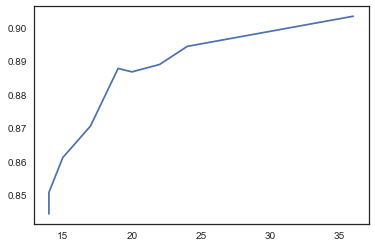

In [75]:
n = []
cv_accuracy = []
for thresh in thresholds:
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]

    # training model
    selection_model = RandomForestClassifier()
    # perform cross-validation
    scores = cross_val_score(selection_model, X_traintest_selected, y_traintest_sampled, cv=5)
     # compute mean cross-validation accuracy
    accuracy = np.mean(scores)    
    cv_accuracy.append(accuracy)
    n.append(X_traintest_selected.shape[1])
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, X_traintest_selected.shape[1], accuracy*100.0))
plt.plot(n, cv_accuracy, label="cv accuracy")

In [77]:
def feature_selection(thresh, X_traintest_sampled, y_traintest_sampled, X_valid):
    # select features using median
    select = SelectFromModel(
        RandomForestClassifier(n_estimators=500, random_state=0),
        threshold=str(thresh)+"*median")

    select.fit(X_traintest_sampled, y_traintest_sampled)
    idxs_selected = select.get_support(indices=True)

    X_traintest_selected = X_traintest_sampled.iloc[:, idxs_selected]
    X_valid_selected = X_valid.iloc[:, idxs_selected]
    return X_traintest_selected, X_valid_selected

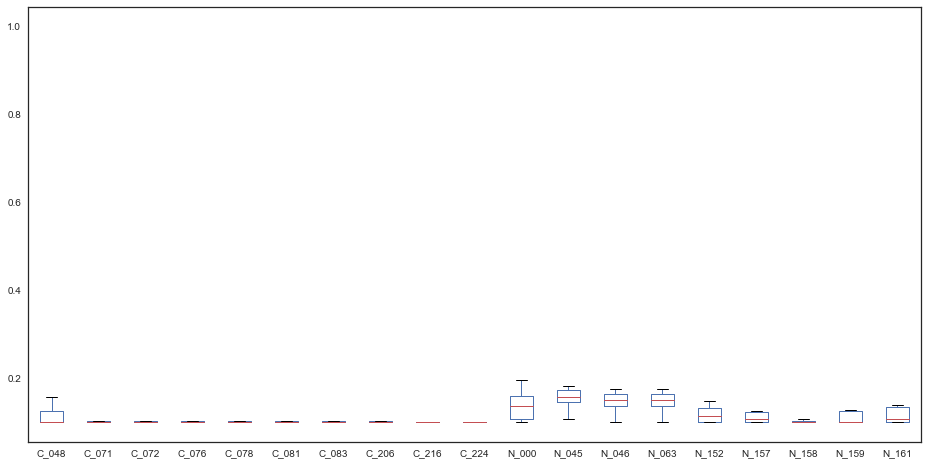

In [78]:
X_traintest_selected, X_valid_selected = feature_selection(10, X_traintest_sampled, y_traintest_sampled, X_valid)
X_traintest_selected.plot.box(figsize=(16,8))

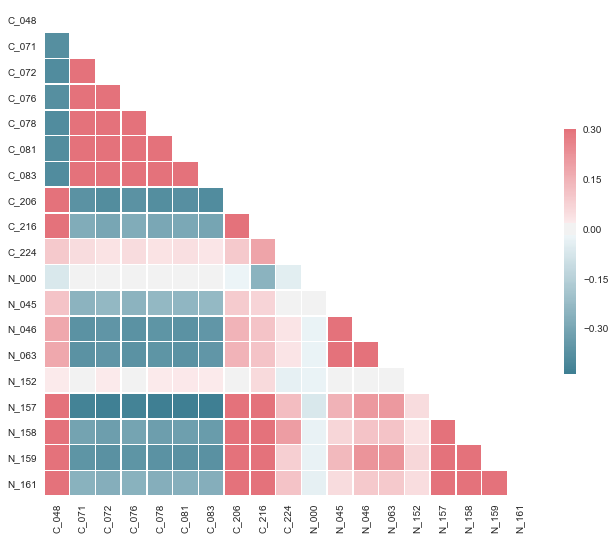

In [79]:
sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=X_traintest_selected,
                 columns=list(X_traintest_selected))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [143]:
pipe = pipeline.Pipeline([('preprocessing', None), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
     'classifier__n_estimators': [100, 500, 1000],
     'classifier__bootstrap': [True, False],
     'classifier__criterion': ['gini', 'entropy']},
    {'classifier': [KNeighborsClassifier()], 
     'preprocessing': [StandardScaler(), None],
     'classifier__n_neighbors': [3, 5, 10]},
    {'classifier': [GaussianNB()], 'preprocessing': [None]}]
     
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_traintest_selected, y_traintest_sampled)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_valid_selected, y_valid_sampled)))
print("Best parameters: {}".format(grid.best_params_))
# grid.grid_scores_

Best cross-validation accuracy: 0.87
Test set score: 0.87
Best parameters: {'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__n_estimators': 500}


In [146]:
pipe = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=100, gamma=0.01, probability=True))])
pipe.fit(X_traintest_selected, y_traintest_sampled)
print("Valid set score: {:.3f}".format(pipe.score(X_valid_selected, y_valid_sampled)))

Test set score: 0.822


In [145]:
rf = RandomForestClassifier(n_estimators=500, criterion = 'gini')
rf.fit(X_traintest_selected, y_traintest_sampled)
print("Valid set score: {:.3f}".format(rf.score(X_valid_selected, y_valid_sampled)))

Test set score: 0.876


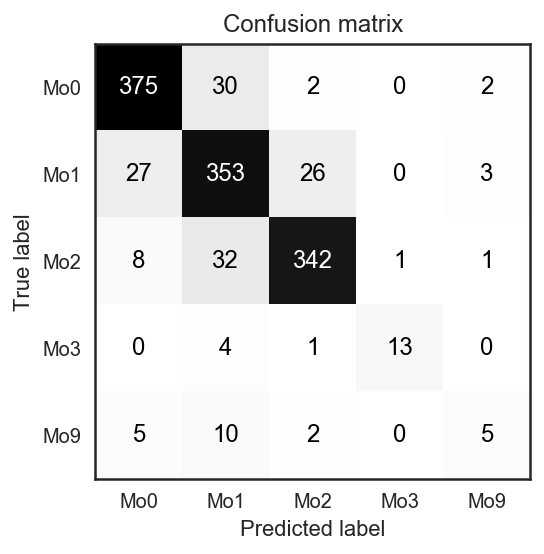

In [147]:
target_names = np.array(le_test.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_valid_sampled, rf.predict(X_valid_selected)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

<Container object of 5 artists>

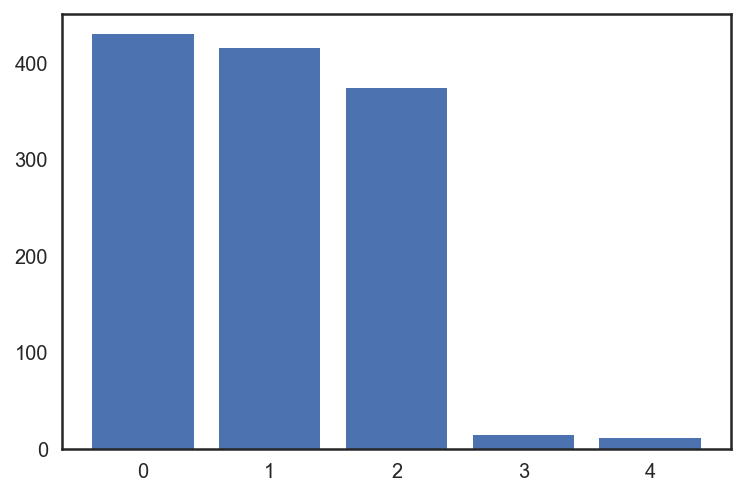

In [149]:
results = pd.DataFrame(rf.predict(X_valid_selected), columns=['predict'])
results['y'] = y_valid_sampled
predicts = results['predict'].value_counts()
plt.bar(range(len(predicts)), predicts)

In [150]:
predicts

1    429
0    415
2    373
3     14
4     11
Name: predict, dtype: int64

In [90]:
Mo0 = y_valid.index[y_valid==0].tolist()
Mo1 = y_valid.index[y_valid==1].tolist()
Mo2 = y_valid.index[y_valid==2].tolist()
Mo3 = y_valid.index[y_valid==3].tolist()
Mo9 = y_valid.index[y_valid==4].tolist()

In [151]:
Mo0 = results.index[results['y']==0].tolist()
Mo1 = results.index[results['y']==1].tolist()
Mo2 = results.index[results['y']==2].tolist()
Mo3 = results.index[results['y']==3].tolist()
Mo9 = results.index[results['y']==4].tolist()

In [76]:
shap.initjs()

In [153]:
explainer = shap.KernelExplainer(rf.predict_proba, X_valid_selected)

In [154]:
with Timer('SHAP'):
    shap_values_Mo3 = explainer.shap_values(X_valid_selected.iloc[Mo3,:])

100%|██████████| 18/18 [31:27<00:00, 104.85s/it]

[SHAP]
Elapsed: 1887.262834072113


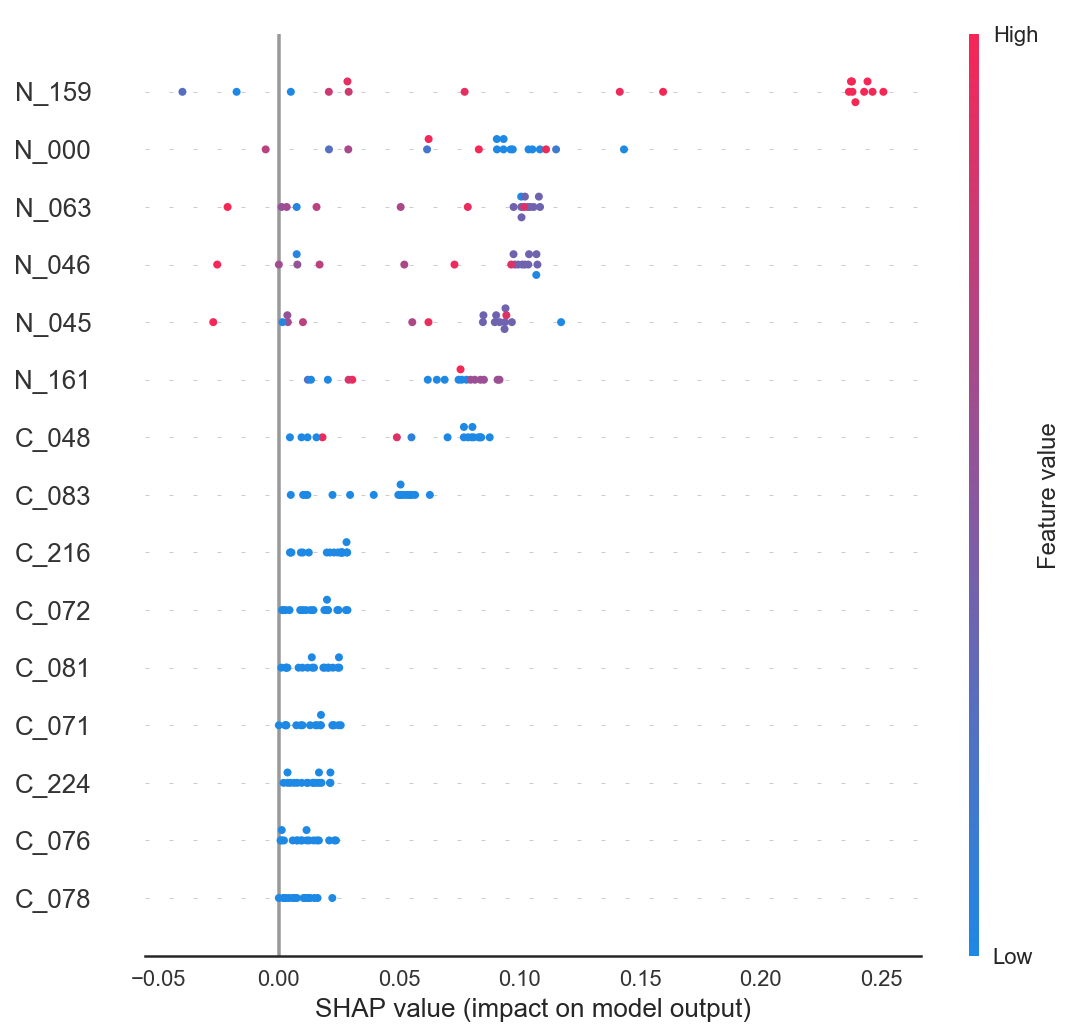

In [155]:
shap.summary_plot(shap_values_Mo3[3], X_valid_selected.iloc[Mo3,:])

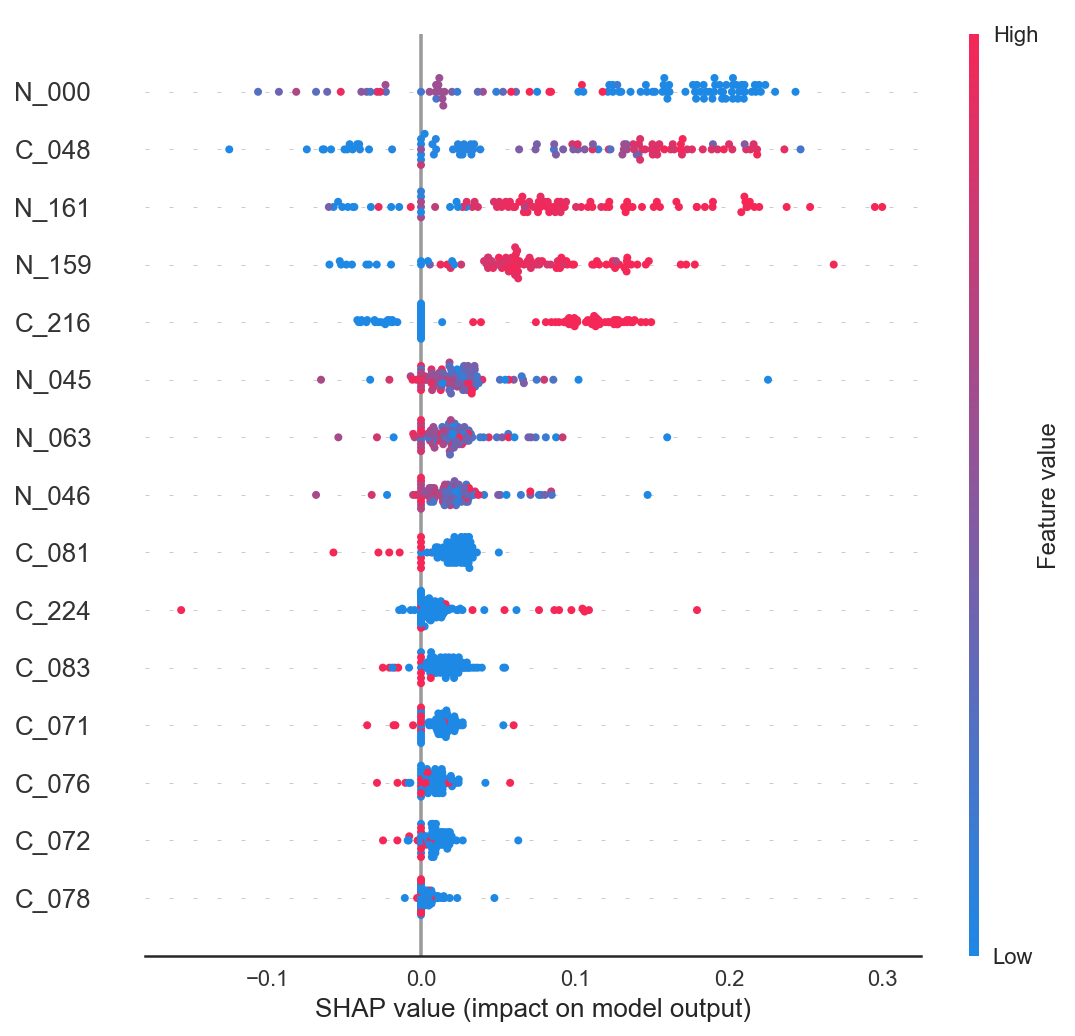

In [237]:
shap.summary_plot(shap_values_Mo2[2], X_valid_selected.iloc[idx_Mo2,:])

In [233]:
import random
with Timer('SHAP'):
    idx_Mo2 = random.sample(Mo2, 100)
    shap_values_Mo2 = explainer.shap_values(X_valid_selected.iloc[idx_Mo2,:])

100%|██████████| 100/100 [2:41:39<00:00, 97.00s/it] 

[SHAP]
Elapsed: 9699.538155078888


In [234]:
with Timer('SHAP'):
    idx_Mo1 = random.sample(Mo1, 100)
    shap_values_Mo1 = explainer.shap_values(X_valid_selected.iloc[idx_Mo1,:])

100%|██████████| 100/100 [2:50:34<00:00, 102.34s/it] 

[SHAP]
Elapsed: 10234.156418085098


In [190]:
with Timer('SHAP'):
    idx_Mo0 = random.sample(Mo0, 100)
    shap_values_Mo0 = explainer.shap_values(X_valid_selected.iloc[idx_Mo0,:])

100%|██████████| 100/100 [3:29:16<00:00, 125.56s/it] 

[SHAP]
Elapsed: 12556.341022014618


In [238]:
with Timer('SHAP'):
    shap_values_Mo9 = explainer.shap_values(X_test_selected.iloc[Mo9,:])

100%|██████████| 22/22 [38:04<00:00, 103.85s/it]

[SHAP]
Elapsed: 2284.6652731895447


In [80]:
# Write the shap values to csv files
for lists, names in zip([shap_values_Mo0, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3, shap_values_Mo9], ["shap_values_Mo0", "shap_values_Mo1", "shap_values_Mo2", "shap_values_Mo3", "shap_values_Mo9"]):#, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3, shap_values_Mo9]:
    test_list = lists
    test_array = np.vstack(test_list)
    test_df = pd.DataFrame(test_array)
    test_df.to_csv("output_cluster_"+names+".csv")
    test_df2 = pd.read_csv("output_cluster_"+names+".csv", index_col=0)
    test_array2 = np.array(test_df2)
    test_list2 = np.split(test_array2, 5)
    print(all([np.allclose(x, y) for x, y in zip(test_list, test_list2)]))#True

True
True
True
True
True


In [85]:
# Read shpa values from csv files
for lists, names in zip([shap_values_Mo0, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3], ["shap_values_Mo0", "shap_values_Mo1", "shap_values_Mo2", "shap_values_Mo3"]):#, shap_values_Mo1, shap_values_Mo2, shap_values_Mo3, shap_values_Mo9]:
    test_df2 = pd.read_csv("output_cluster_"+names+".csv", index_col=0)
    test_array2 = np.array(test_df2)
    test_list2 = np.split(test_array2, 5)
#    print(all([np.allclose(x, y) for x, y in zip(test_list, test_list2)]))#True

In [93]:
shap.force_plot(shap_values_Mo2[2], X_test_selected.iloc[Mo2,:])

In [81]:
xgb_traintest = xgboost.DMatrix(X_traintest_selected, label=y_traintest_sampled)
xgb_valid = xgboost.DMatrix(X_valid_selected, label=y_valid)

In [91]:
xgb_valid_Mo0 = xgboost.DMatrix(X_valid_selected.iloc[Mo0,:], label=y_valid)
xgb_valid_Mo1 = xgboost.DMatrix(X_valid_selected.iloc[Mo1,:], label=y_valid)
xgb_valid_Mo2 = xgboost.DMatrix(X_valid_selected.iloc[Mo2,:], label=y_valid)
xgb_valid_Mo3 = xgboost.DMatrix(X_valid_selected.iloc[Mo3,:], label=y_valid)
xgb_valid_Mo9 = xgboost.DMatrix(X_valid_selected.iloc[Mo9,:], label=y_valid)

In [93]:
# use validation set to choose # of trees
params = {'max_depth':20, 'n_estimators':500,
         'objective': 'multi:softmax', 'num_class': 5
}

xgb = xgboost.train(params, xgb_traintest, 100)

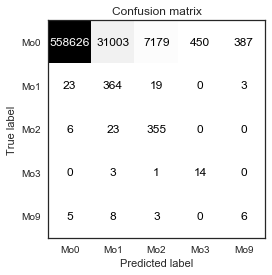

In [94]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_valid, xgb.predict(xgb_valid)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [102]:
print("Accuracy score: {:.3f}".format(accuracy_score(y_valid, xgb.predict(xgb_valid))))

print("F1-micro score: {:.3f}".format(f1_score(y_valid, xgb.predict(xgb_valid), average="micro")))
print("F1-weighted score: {:.3f}".format(f1_score(y_valid, xgb.predict(xgb_valid), average="weighted")))

Accuracy score: 0.935
F1-micro score: 0.935
F1-weighted score: 0.965


In [ ]:
print(cohen_kappa_score(y_valid, xgb.predict(xgb_valid)))
print(f1_score(y_valid, xgb.predict(xgb_valid), average=None))
print(precision_score(y_valid, xgb.predict(xgb_valid), average=None))
print(recall_score(y_valid, xgb.predict(xgb_valid), average=None))

0.0358952236529
[ 0.96622604  0.02288588  0.08940939  0.05809129  0.02870813]


In [ ]:
shap_values_xgb_Mo0 = xgb.predict(xgb_valid_Mo0, pred_contribs=True)
shap_values_xgb_Mo1 = xgb.predict(xgb_valid_Mo1, pred_contribs=True)
shap_values_xgb_Mo2 = xgb.predict(xgb_valid_Mo2, pred_contribs=True)
shap_values_xgb_Mo3 = xgb.predict(xgb_valid_Mo3, pred_contribs=True)
shap_values_xgb_Mo9 = xgb.predict(xgb_valid_Mo9, pred_contribs=True)

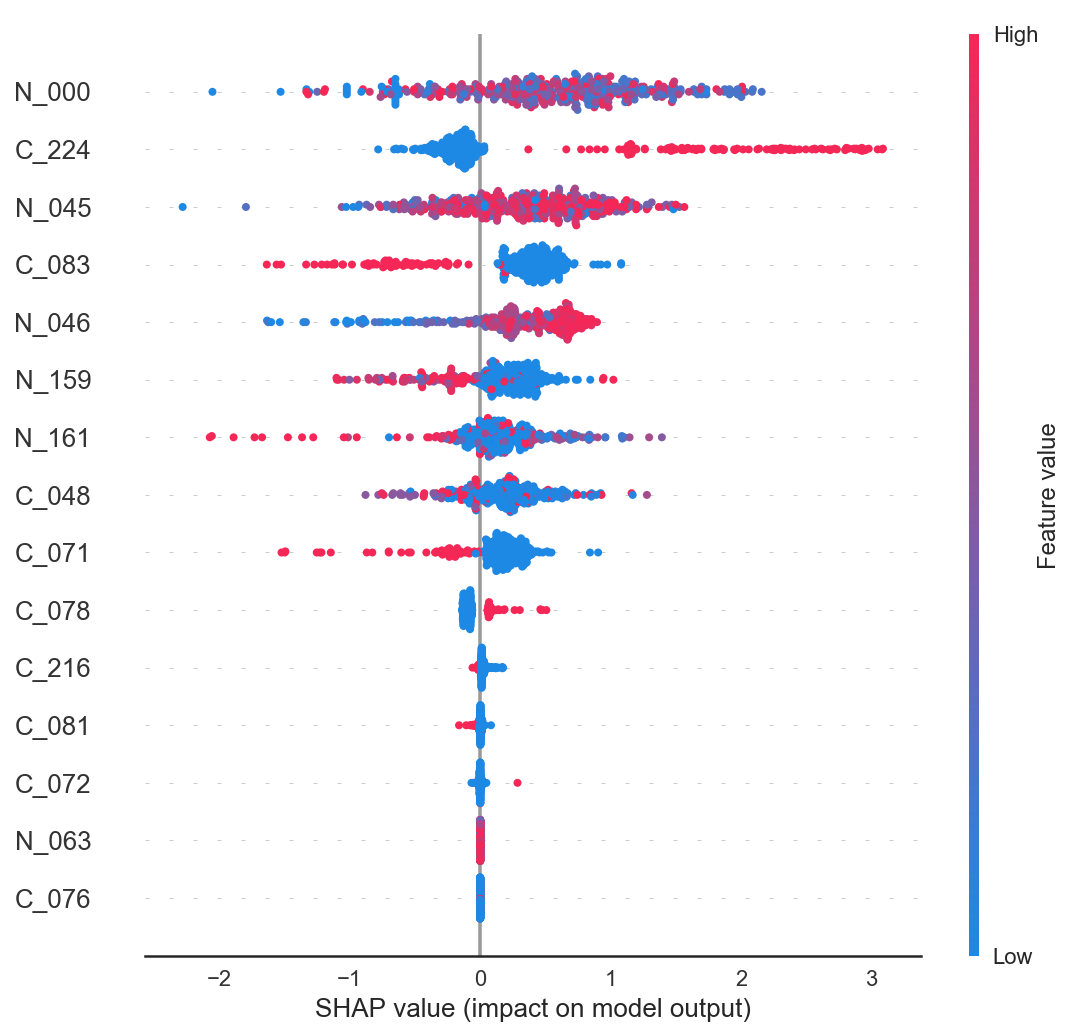

In [225]:
shap.summary_plot(shap_values_xgb_Mo1[:, 1, :], X_valid_selected.iloc[Mo1,:])

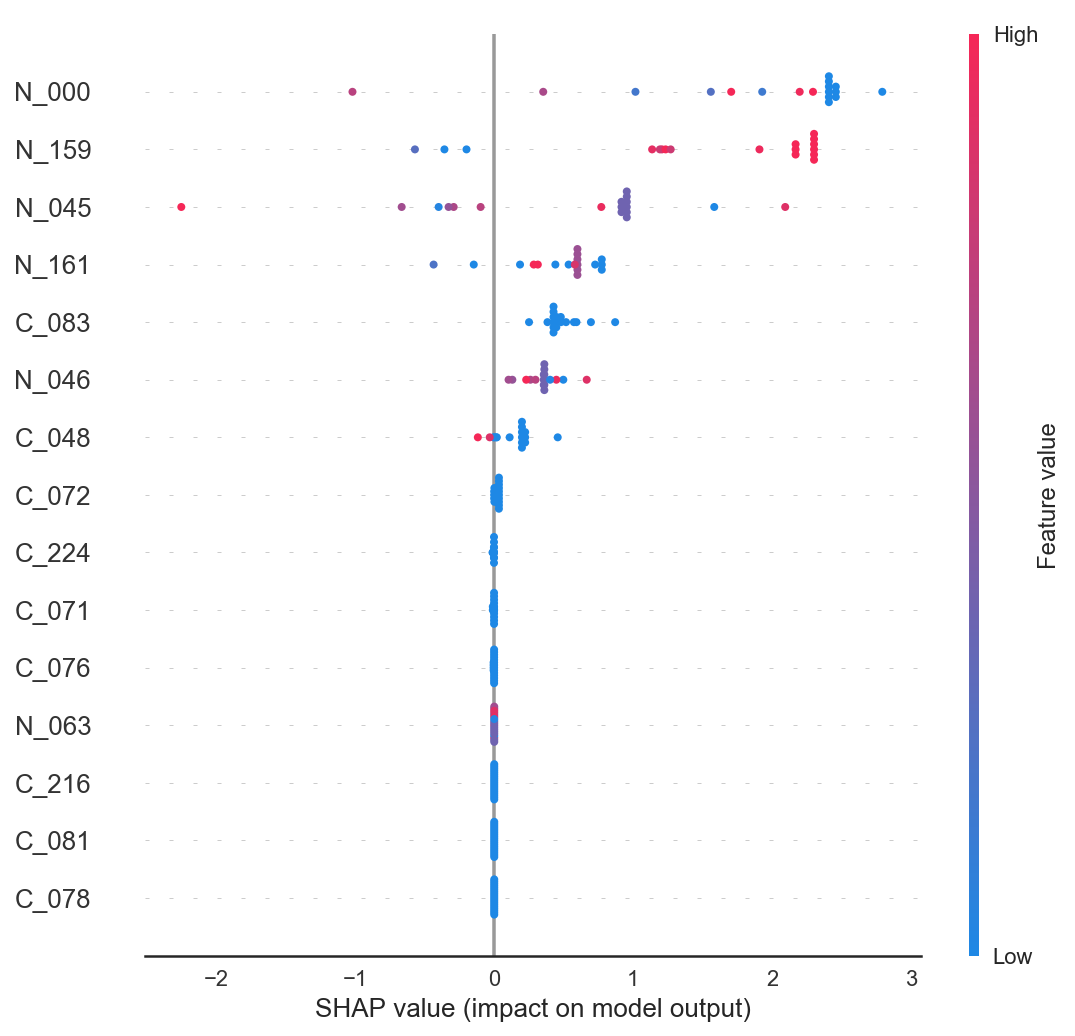

In [228]:
shap.summary_plot(shap_values_xgb_Mo3[:, 3, :], X_valid_selected.iloc[Mo3,:])

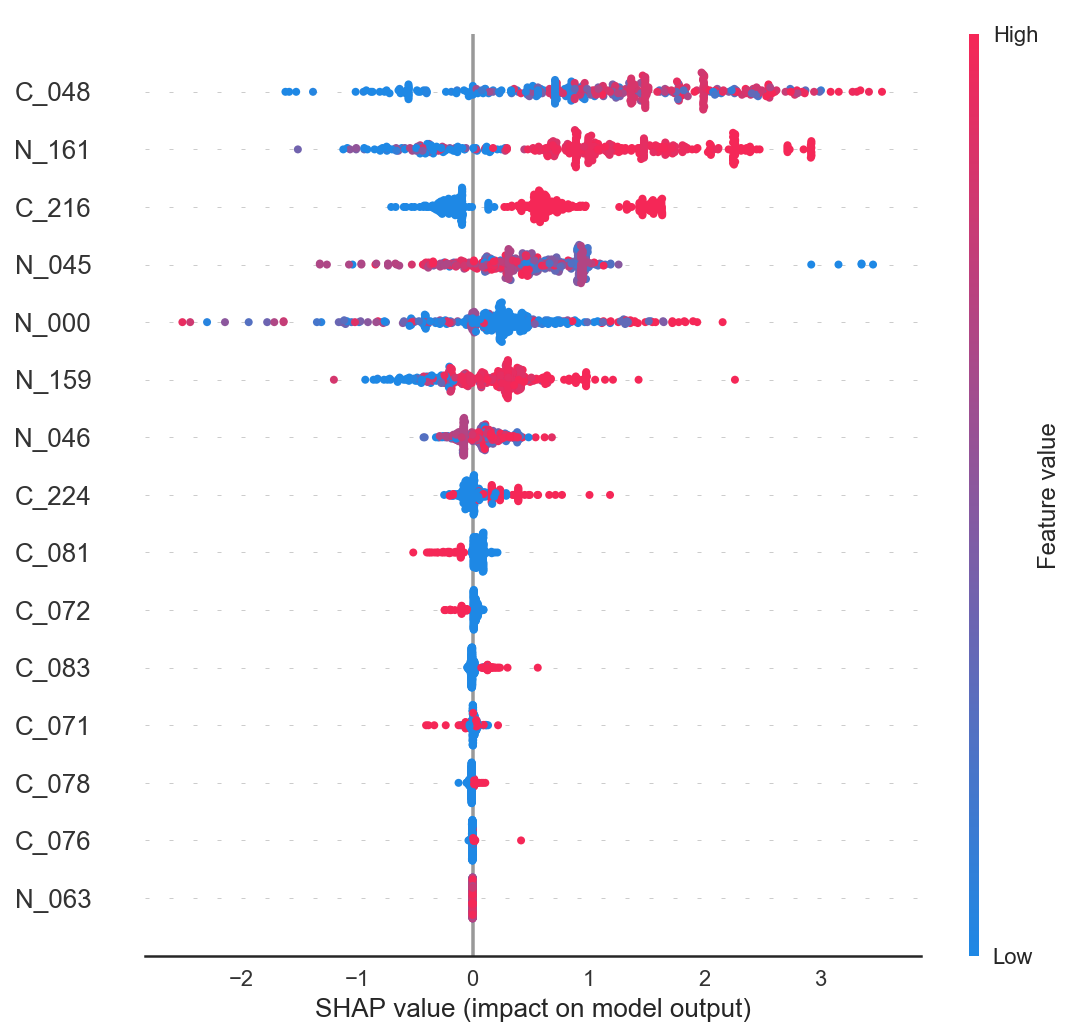

In [229]:
shap.summary_plot(shap_values_xgb_Mo2[:, 2, :], X_valid_selected.iloc[Mo2,:])

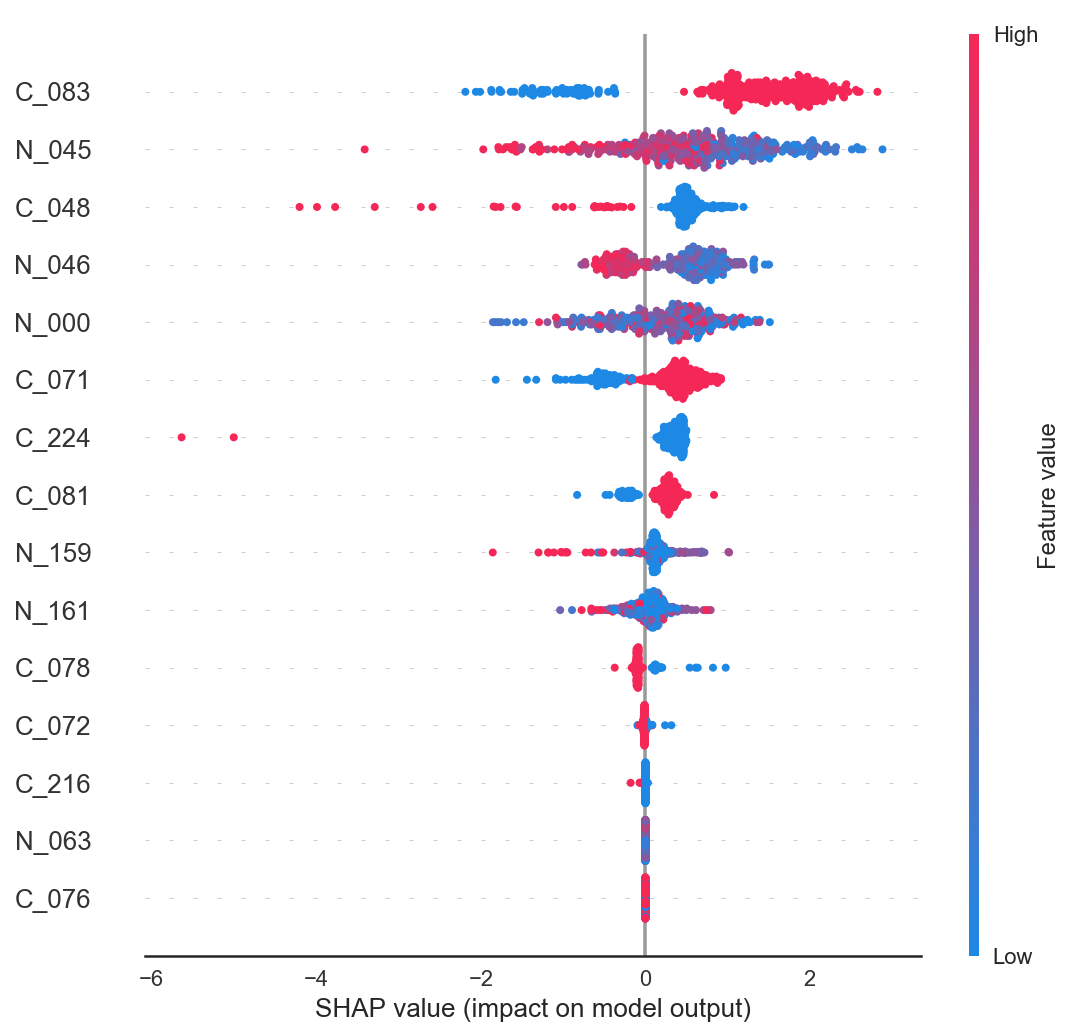

In [230]:
shap.summary_plot(shap_values_xgb_Mo0[:, 0, :], X_valid_selected.iloc[Mo0,:])

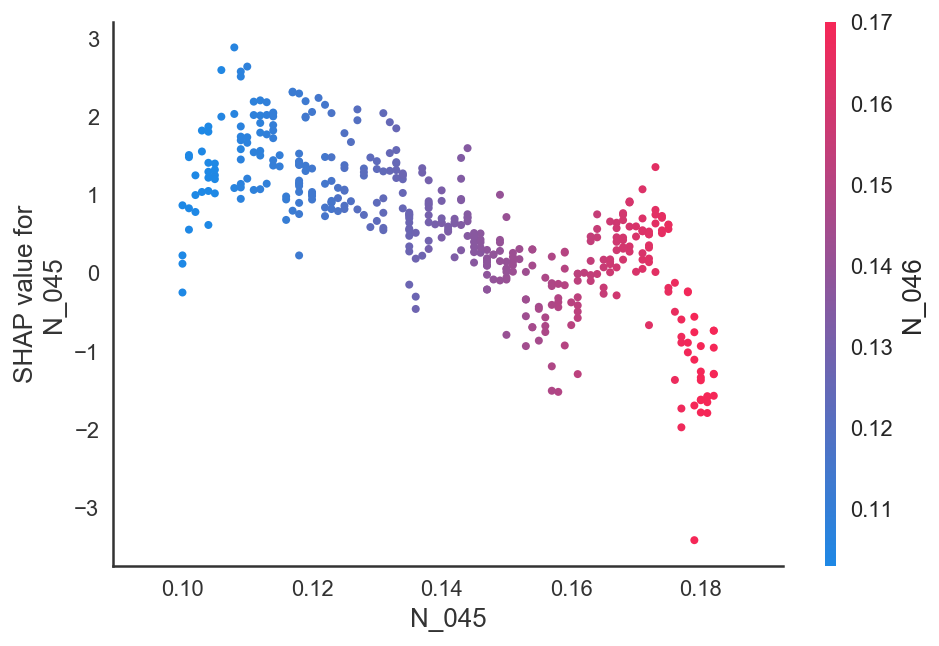

In [232]:
shap.dependence_plot("N_045", shap_values_xgb_Mo0[:, 0, :], X_valid_selected.iloc[Mo0,:])